In [1]:
# student ID : F218686

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# pre set the path of the data 
!ls "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
file1 = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsLSA.csv"
file2 = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsQueryRelevantID.csv"
file3 = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsSummarisationTargets.csv"

JewelleryReviewsLSA.csv		     JewelleryReviewsSummarisationTargets.csv
JewelleryReviewsQueryRelevantID.csv


In [4]:
import pandas as pd
# import the file using pandas 
df = pd.read_csv(file1)
print(df)

        ID                                            Reviews  Ratings
0    32767  i expect like regular size of ring,but this on...        1
1    15959  I ordered a ring that stated Toe Ring" in the ...        1
2    43515  This ring is a beautiful ring but the first sh...        1
3    46347  This ring is a beautiful ring but the first sh...        1
4    30720  This is a huge waste of money I had it for abo...        1
..     ...                                                ...      ...
195  44489  I just got these yesterday as a Christmas gift...        5
196  44490  These are very good quality. They are light we...        5
197  56830  I really liked these earrings. However, i agre...        3
198  56830  I really liked these earrings. However, i agre...        3
199  56830  I really liked these earrings. However, i agre...        3

[200 rows x 3 columns]


In [5]:
# making the unclean docs list from the dataframe
unclean_docs = df['Reviews'].tolist()
print(unclean_docs)

['i expect like regular size of ring,but this one look like a ring for toy or something funy, the MM of our rings is 5MM and this ring may be is 1MMso ridiculousMartin1/5 ct.tw Round Diamond Solitaire Ring in 18k White Gold', 'I ordered a ring that stated Toe Ring" in the description. The ring came very quickly but was not a toe ring. I don\'t know anyone with a size 8 toe. If you know anyone please direct them to this seller! Is it a wedding band, toe ring or thumb ring? Pick one!', 'This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. And this time 1 diamond missing on the shoulder of the ring. I returned it for a refund. Thanks alot Amazon.', 'This ring is a beautiful ring but the first shipment of this rin

I m going to clean the reviews in the dataframe.

In [6]:
df["Reviews"] = df["Reviews"].str.lower()
df.head()


,ID,Reviews,Ratings
0,32767,"i expect like regular size of ring,but this on...",1
1,15959,"i ordered a ring that stated toe ring"" in the ...",1
2,43515,this ring is a beautiful ring but the first sh...,1
3,46347,this ring is a beautiful ring but the first sh...,1
4,30720,this is a huge waste of money i had it for abo...,1


In [7]:
# cleaning the review by removing the punctuation
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["Reviews"] = df["Reviews"].apply(lambda text: remove_punctuation(text))
df.head()

,ID,Reviews,Ratings
0,32767,i expect like regular size of ringbut this one...,1
1,15959,i ordered a ring that stated toe ring in the d...,1
2,43515,this ring is a beautiful ring but the first sh...,1
3,46347,this ring is a beautiful ring but the first sh...,1
4,30720,this is a huge waste of money i had it for abo...,1


In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# cleaning the review by removing stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Reviews"] = df["Reviews"].apply(lambda text: remove_stopwords(text))
df.head()

,ID,Reviews,Ratings
0,32767,expect like regular size ringbut one look like...,1
1,15959,ordered ring stated toe ring description ring ...,1
2,43515,ring beautiful ring first shipment ring scratc...,1
3,46347,ring beautiful ring first shipment ring scratc...,1
4,30720,huge waste money month part holds symbol neckl...,1


In [10]:
# i tried stemming but found out that the lemmanization works the best 
# from nltk.stem.porter import PorterStemmer

# stemmer = PorterStemmer()
# def stem_words(text):
#     return " ".join([stemmer.stem(word) for word in text.split()])

# df["Reviews"] = df["Reviews"].apply(lambda text: stem_words(text))
# df.head()   


In [11]:
# create a new csv file with all the clean reviews called cleaned_reviews
df.to_csv("cleaned_reviews.csv", index=False)

# Question 2

## 2a) Making the LSI model abd get the top 10 similar reviews

In [12]:
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
# from keras.preprocessing.text import Tokenizer
from pandas import DataFrame
from matplotlib import pyplot
import random
import nltk
import numpy
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import rand
from sklearn.metrics.pairwise import cosine_similarity
from numpy import argsort
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter
import pprint
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

wordnet_lemmatizer = WordNetLemmatizer()

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# split train and test
def random_sample(num1, num2):
    dataList = list(range(num1))
    TrainIndex = []
    for i in range(num2):
        randIndex = int(random.uniform(0, len(dataList)))
        TrainIndex.append(dataList[randIndex])
        del (dataList[randIndex])
    TestIndex = dataList
    return TrainIndex, TestIndex

# load doc into memory
def load_doc_lines(filename):
    file = open(filename, 'rt')
    lines = list()
    # read all text as lines
    while 1:

        line = file.readline()
        if not line:
            break
        pass
        lines.append(line.strip("\n"))
        # close the file
    file.close()
    return lines

# turn a doc into clean tokens
def clean_doc(doc):
    array = []
    # split into tokens by white space
    tokens = doc.split()
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    # i added an extra function here to check if there are empty list and remove it 
    if len(tokens) > 0:
        array.append(tokens)
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(doc):
    # load the doc
    # doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    # tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(files):
    lines = list()
    # walk through all files in the folder
    for doc in files:
        # print(len(doc))
        line = doc_to_line(doc)
        # add to list
        lines.append(line)
    return lines

# prepare words encoding of docs
def prepare_data(train_docs, mode, vocab):
    # encode training data set
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm='l2')
    Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))
    return Xtrain

# load the dataset #########################################
ArRe_train_lines = load_doc_lines("cleaned_reviews.csv")
# i am removing the heading because the first list if the headings
ArRe_train_lines = ArRe_train_lines[1:]
pprint.pprint(ArRe_train_lines)
train_docs = process_docs(ArRe_train_lines)

# generate vocabulary
vocab = []
for lines in train_docs:
  tt = lines.split()
  for line in tt:
    if line not in vocab:
      vocab.append(line)
# prepare the model 
Xtrain = prepare_data(train_docs, 'tfidf', vocab)
trunc_SVD_model = TruncatedSVD(n_components=130)
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['32767,expect like regular size ringbut one look like ring toy something funy '
 'mm rings 5mm ring may 1mmso ridiculousmartin15 cttw round diamond solitaire '
 'ring 18k white gold,1',
 '15959,ordered ring stated toe ring description ring came quickly toe ring '
 'dont know anyone size 8 toe know anyone please direct seller wedding band '
 'toe ring thumb ring pick one,1',
 '43515,ring beautiful ring first shipment ring scratches diamond missing 2 '
 'diamonds shoulder ring returned ring replacement ring second ring even worse '
 'clearly visible white scratch right middle black diamond look great time 1 '
 'diamond missing shoulder ring returned refund thanks alot amazon,1',
 '46347,ring beautiful ring first shipment ring scratches diamond missing 2 '
 'diamonds shoulder ring returned ring replacement ring second ring even worse '
 'clearly visible white scratch right middle black diamond look great time 1 '
 'diamond missing shoulder ring returned refund thanks alot amazon,1',
 '30

[nltk_data]   Package omw-1.4 is already up-to-date!


query retrieval

In [13]:
# preprocess query
def preprocess_query(review, mode, vocab):
	# clean
	tokens = clean_doc(review)
	# convert to line
	line = ' '.join(tokens)
	# encode
	vectorizer = CountVectorizer(vocabulary=vocab)
	transformer = TfidfTransformer(norm='l2')
	encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
	return encoded

querys = ['The ring is a great gift. My friend loves it',
          'horrible bad quality bracelet',
          'arrived promptly and happy with the seller',
          'wear it with casual wear',
          'i expected better quality. i will return this item',
          'looks beautiful. The design is pretty. pefect and color is light',
          'This ring looks nothing like the picture. the diamonds are small and not very noticeable',
          'braclet looked just like its picture and is nice quality sterling silver.',         
]
for query in querys:
  # retrieval
  encoded_query = preprocess_query(query, 'tfidf', vocab)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)
  # print("Similarities shape: " + str(similarities.shape))

  Top_n_reviews=10
  # we sort the similarities indexes to get the to 10
  indexes = np.argsort(similarities.flat)[::-1]

  print('\n' + 'Query: ' + query)
  # we loop 10 times and print the 10 best reviews
  for i in range(Top_n_reviews):
    print("Top " + str(i+1) + ' result:')
    print("Reviews ID: " + str(df.iloc[indexes[i]]['ID']))
    print(str(df.iloc[indexes[i]+1]['Reviews']))




Query: The ring is a great gift. My friend loves it
Top 1 result:
Reviews ID: 58481
birthday gift 16 yo niece loves ring happy received
Top 2 result:
Reviews ID: 58595
love ring flowers go way around ring fits ring finger ever find mr right doesnt buy engagement ring use engagement ring getting debt marriage
Top 3 result:
Reviews ID: 34483
owned triple roll ring three rings slowly broke purchased far none individual rings broken yet
Top 4 result:
Reviews ID: 25080
still wearing pinky ring trinity knotfinally pinky ring turn finger green
Top 5 result:
Reviews ID: 36164
wife loves ring great gift extremelly cheap high quality
Top 6 result:
Reviews ID: 44591
ring pretty flexible turned good ordered ring finger size made look better pinkie ring
Top 7 result:
Reviews ID: 33620
ring exactly wanted actually bought another wasnt quite solidly made ring thanks great ring
Top 8 result:
Reviews ID: 17309
ive owned several claddagh rings years lost last one received one gift recently truly love s

now let's import other file. we will need it for reviews and ids.

In [14]:
# now i m importing the second file where the ground truth file reviews id are.
df_reviews = pd.read_csv(file2)
df_reviews.head(10)


,Query1,Query2,Query3,Query4,Query5,Query6,Query7,Query8,Unnamed: 8,Query1Text,Query2Text,Query3Text,Query4Text,Query5Text,Query6Text,Query7Text,Query8Text
0,36164,57123.0,33251.0,40373.0,13373.0,45860.0,209.0,642.0,NaN,The ring is a great gift. My friend loves it,horrible bad quality bracelet,arrived promptly and happy with the seller,wear it with casual wear,i expected better quality. i will return this ...,looks beautiful. The design is pretty. pefect ...,This ring looks nothing like the picture. the ...,braclet looked just like its picture and is ni...
1,58481,25299.0,17304.0,28648.0,17607.0,46500.0,28542.0,10642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26246,55017.0,50019.0,37486.0,41459.0,27474.0,216.0,37794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2033,7432.0,27679.0,30640.0,54748.0,43945.0,47345.0,45518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48779,2114.0,6158.0,2131.0,33571.0,52837.0,11356.0,3494.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,34523,40871.0,22408.0,19852.0,NaN,12358.0,33632.0,735.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9726,NaN,29722.0,2134.0,NaN,41319.0,38637.0,10037.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,56494,NaN,36677.0,36585.0,NaN,39932.0,7110.0,41872.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,49525,NaN,2780.0,26535.0,NaN,45146.0,6649.0,28542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,45278,NaN,17944.0,51474.0,NaN,50197.0,51356.0,53409.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
import math

# this function removes all the nan in the list imported from the dataframe and also convert it into int
def list_clean(list):
  list = ','.join(map(str, list))
  list = [float(x) for x in list.split(',')]
  list = [x for x in list if not math.isnan(x)]
  list = [int(x) for x in list]
  return list

query1_list = df_reviews['Query1'].tolist()
query1_list = list_clean(query1_list)
 
query2_list = df_reviews['Query2'].tolist()
query2_list = list_clean(query2_list)

query3_list = df_reviews['Query3'].tolist()
query3_list = list_clean(query3_list)

query4_list = df_reviews['Query4'].tolist()
query4_list = list_clean(query4_list)

query5_list = df_reviews['Query5'].tolist()
query5_list = list_clean(query5_list)

query6_list = df_reviews['Query6'].tolist()
query6_list = list_clean(query6_list)

query7_list = df_reviews['Query7'].tolist()
query7_list = list_clean(query7_list)

query8_list = df_reviews['Query8'].tolist()
query8_list = list_clean(query8_list)

# Create a 2D list containing each of the original lists as a separate sublist
list_of_Ids = [
    query1_list,
    query2_list,
    query3_list,
    query4_list,
    query5_list,
    query6_list,
    query7_list,
    query8_list
]



this is the indexes[58481 58595 34483 25080 36164 44591 33620 17309 49525 11269 17273 45278
 56494 37896 25378 41876 48779 37864 26246 28250 10535 47910 35526 46347
 32496 43515 39606 56679 35694  6421 23979 50640 44135 33858 45289 48216
 45203 30773 56342 49855 40749 17442 33813 27793 34529 51030  8110  2520
 15959 19647 32767 44534 51396 33632 39620 26535 14499  3978 10209 50609
  6135 42604  6522 34523 27858 53693  9441 30926 22058 21185 48781  6649
 19548 11356 18988 55505 55511 48772 33009 54953  2033 44358 57009 39496
 43839 52663 13559  1185 50467 20090 50650 11856 11135 51356 33746  7110
 22946   216  8341   943 28474 24452 42026  9050 38637 31657 49720 34266
 42077 45146 41319 22408 10037 41872 55017  9726 47345 44126 19944 49216
 54548 29722 25299  2131 36165 10612 17607 53409 17944  2185 53660 45548
 12358 51474 40871 57123 10758  4375 52375 45860 12483 39932 11247 45856
 30720 41459 10642   735   535 43945 27474 33571 28543 27679 33251 28542
 21070 36727 50197 38305 17166 3

<ipython-input-16-de64b7665ae3>:135: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


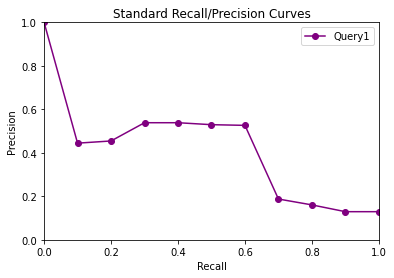

this is the indexes[55017 57123  7432 25299 40871  2114 33571 52837 45548   642 32674 41889
 10758  4375 13373 22058 44490  8110 45518 27679 10037 51907 17607 38305
 30720 41459 56865 37794 36727 45856 36164 56679 18988 55505 55511 30773
 46500 19647 50467 44358 37896 28542 36585 51030 26246  2780 30640 37486
 21070 34529 24452  6421   216  3978   943 41872 17166 49720 37864  2033
 17442 15959   535 49855   735 36677 58481 48779 56342 23979  6649 33813
 33858 11269 40749 17304 33251 34483 48781 40373 34266 11247 50019 11087
 38637  7110 28474 39620 11856  2185 36165  3494 29722 12358 10642 45203
 48216 25378 33746 19852 44135 50640 51356 51396 44534 56830 56830 56830
 12483 50197 52375  2520  8341 45289 17944 46347 32496 43515 35526 41319
 10535 28250  2131  2134   209 53409 10612 22408 51474 27474 43945 11135
 45146  9050 20090 50650  3865  6158 56330 27793 33632 45860 49525 53693
 44126 13559 28648 54953 33009 39496 57009 26535  6522 14499  1816 53660
 42604 28543 22946  9441 41876 4

<ipython-input-16-de64b7665ae3>:135: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


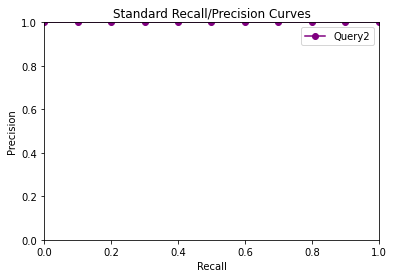

this is the indexes[22058 26246  9726 13373 41889 52867  2780 22408   216 54748 37864 51907
 51356 45856 56679 15959 39620 31657 44490 45278 17273 49525 44358 28648
 34529  3978 23979 33620 51030 30720 19548  9441 42026 49216 17304 50467
 17944 17166 30926  1816 42604  6158 56342 49720   535  8341  8110 34523
  7110 28474  2131 33632 11135   642 29722 51474 56865 11856 10642 41319
   209 19944  1185 11247 41459  6421  3865 39606 53693 45146 33858 27679
 38637 40871 37486 56330  2185  7432 52663 50197 37794  9050 52375 25299
  2134 35526 43515 46347 32496 19647 10209 45548 40373  6522 28543 40749
 56830 56830 56830 57123 30640 48216 45203 43945 27474  6649 52837 37896
 22946 26535 55511 55505 18988 12483 44135 50640 11087  3494 54548 54953
 33009 56494 30773 10535 28250 33813 45518 33571 44489 53660 20090 50650
 48772 53409 25080 33746 14499 39496 57009  2520 13559 12358 45289 44591
 10758  4375 35694 45860 51396 44534 17607 32674 27793 49855 34483 25378
 17309 28542 41872 55017 44126 1

<ipython-input-16-de64b7665ae3>:135: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


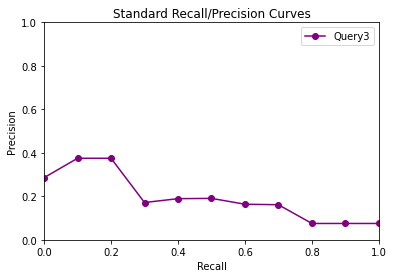

this is the indexes[53660 30640 37486 19852 28648 54548 50609  6135 28474 33746 44135 50640
 44126 27858 52663 21070 45278 10037 26535 51474 11087 13559   535 33620
 40373 53750  2131 49855 27793 56679 39620 12483 34529 45289 49525  2185
 33813 34266  3978 25080 39606  2114 32767 31657 45146 50019 51356 33858
   735  6421 42604  8110 49216   216 38305   209   642 47345 17166 55017
 42077 33632 17607 50467 33251 53693 32674   943 13373  3865 36677 15959
 19944 37794 22058  6522 36164 11247 20090 50650 19647 48216 45203 46500
 52837 45860 36585 25378 17309 54748  8341 33571  6649 48779 54953 33009
 10758  4375 26246  6158 14499 41876  9726 48781  2780 40871 55511 18988
 55505 10209 28542 51907 56342 44489 35526 32496 43515 46347 52867 41459
 11269 56830 56830 56830 48772  7110   265 23979 43945 27474 58595 50197
 17304 51030 45548 51396 44534 39932 43839 41319 41872 27679 11856 34483
 56330 10535 28250 57123  9441  9050 17273 52375  1816 22946 58481 36727
 57009 39496 29722  3494 25299 2

<ipython-input-16-de64b7665ae3>:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.show()


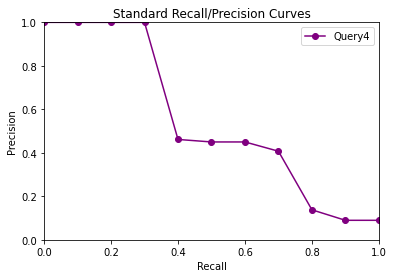

this is the indexes[33571   265 17944 51907  4375 10758 22946 45548 24452 41889 31657 17304
  9726  8110 17607  6158 45146 17273 33251 45856 36677 41459 50467 48772
 44358 34483 41876 43839 57123 33858 15959 25080   216 44490 49525 39606
 36165 56494 30720 23979   943 33813 46500 32674  6421   535 30640 45289
 49216 22058 19647 11269 45278 44489 30926 54748 14499 34266 13373 19852
 10612   209 47345 50197 36585 52663 44135 50640 27679  6522  3865 10642
 11856  2185 39620 10037 53750  2780  2131 44534 51396 58481 19944 50609
  6135 55511 18988 55505 34523 11247 56679   735 56342 42077 20090 50650
 38305 11356  8341 38637 48779 49855  1185 45860 29722 52375 17309 56830
 56830 56830 45203 48216 26535 11087  2134 30773 41872 35694 54953 33009
 12358 51474 51030 35526 43515 46347 32496 27858 34529 49720 52867 28543
 58595 56330 21185 28474 37896 33632 28648 36727 19548 28542 57009 39496
 17442 33746  9050 27793 37794 55017 42026  6649  7432  2114 53409 22408
 27474 43945   642  1816 53693 1

<ipython-input-16-de64b7665ae3>:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.show()


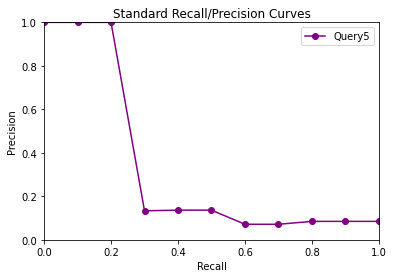

this is the indexes[46500 37794  3494 44490 43945 27474 52375 41319 42077 39932  8341 44126
  7110 10612 42604 41872 45860 51356   735  1816   216 45146 11356 36165
 53409   209   943 44489 38637  2185 30926 10037  6649 11135 17273 24452
 33813 30640 53750 36677  3978 32767 50609  6135 34523 34483 51030 55017
 56679 19548 33632 37864 49855 55511 55505 18988 27793  2520 45289 43515
 32496 35526 46347 44358 34529 25080 22408 35694 50467 28542 40871 56865
 52837 19852 45548  6421 49525 33620 41876 17166 48772 51474 33571  2114
 22058 52663 21185 10535 28250  9726 53693 13373 40749 12483 50019 45278
 40373 37486 31657 33251 36727 41889 37896 17304 56342 48779 29722 19944
   642 28648 10642  2134 56330 49720  4375 10758 42026 17442  7432 47910
 17944 54953 33009 50640 44135 19647  9441  2033 56830 56830 56830  1185
 17309 51907  3865 36585 11087 33746 28474 57009 39496 45203 48216 22946
   535 34266 58481 41459 43839  6158 50650 20090 11247 39606 58595 13559
 45518 50197 10209  6522 45856  

<ipython-input-16-de64b7665ae3>:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.show()


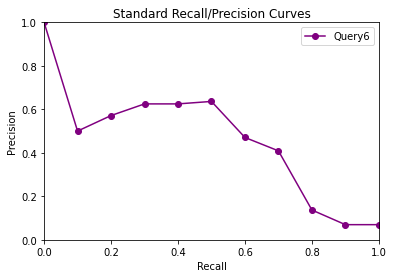

<ipython-input-16-de64b7665ae3>:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.show()


this is the indexes[  209 47345   216  7110 36165  6649 25080 32767 46347 35526 32496 43515
 44358 51356 37864 34483 38637  3494 44490 28250 10535 44534 51396  2185
 11356 42026 49855 22946 27793 50609  6135 34529 37794 33632 45289 17442
 58595 40749 33620   943  6421 51030   735 41872 30926 56679 34523  3978
 44489 53409 47910 23979 50467 39606 33813 19647 15959 45548 10209  2520
 19548 39620 21185  6522 27858 42604 25378 56342 53693 10037 36677  9441
 36164 30773 48772 48781 44591 37896 11269 18988 55505 55511 48779 57009
 39496 54953 33009  1816 10642 28542 45860  1185 45278 41319 27474 43945
   642 13559 52663 24452 50650 20090 52375 43839 45518 17273 11856 56865
 54548 39932 45146  9050 58481 56494 12358 53750 44135 50640 10612 28474
 45203 48216 51907 46500 26246 14499 33858 55017 34266 49720  2033 35694
 33746 11135 33251  7432 41876  9726 27679 45856 12483 53660 44126 54748
 42077 37486 29722 40871 19852  2134 38305 57123 52837 30720 17944 17309
 17166  3865   265   535 22058 2

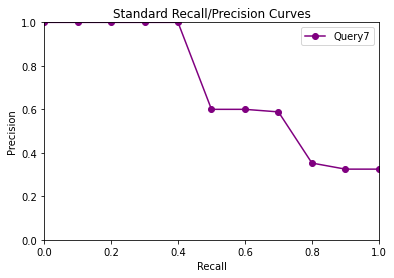

this is the indexes[  642 45518 47345 53409 33632 28542 44490 37794 56865  3494 38637 10642
 36165 40749 10037  2185 25299   209 51907   943 44489  6649 41872  6421
   216 37864   735 57123 11856  7110 36677 11269 25378 50609  6135 39606
 11356 32674 22058 13373 51356 45548 41889 17944 42026 10758  4375 32767
 53750 10535 28250 25080 30640  8110 50467 44358 27679 54548 36727 18988
 55511 55505 38305 39620 42077 12358 41459 46500 45856 47910 17607 33571
 31657 34523 30720 40871 56679 45860 51030 55017 34483 33620 28543  7432
 36164  9441 10209 50019 45289 49525 17442 33746 10612 21185  2520 43839
 49720 53693 48772 26535 36585  6522 52837   265 30926 48781 53660 48779
 52867 42604 54748 24452 43945 27474 17273 45146 19852 14499  3865  2033
  2131 49855 26246  9726 44135 50640 43515 46347 35526 32496 49216 37896
 50650 20090 56830 56830 56830 33251 39932 13559 19944 34529 33009 54953
 44591 48216 45203 30773 21070 33813 56330 57009 39496 12483 52375 45278
  6158  1185 44534 51396 27793 1

<ipython-input-16-de64b7665ae3>:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.show()


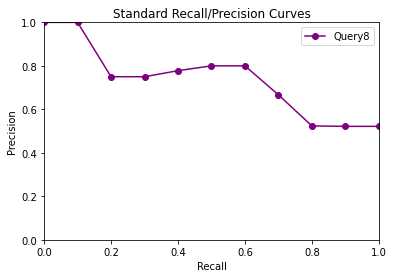


Average Recall, average Precision, average F1-measure: 
average Recall@1~10:  [0.09153503 0.13984089 0.17853136 0.22683723 0.28375687 0.3424794
 0.37144002 0.40821314 0.42564103 0.44567308]
average Precision@1~10:  [0.875      0.6875     0.58333333 0.5625     0.575      0.58333333
 0.55357143 0.546875   0.51388889 0.4875    ]
average F1measure@1~10:  [0.16250808 0.22579365 0.26389319 0.31113154 0.36510327 0.41475279
 0.42785056 0.45064311 0.44910032 0.44984988]


<ipython-input-16-de64b7665ae3>:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")


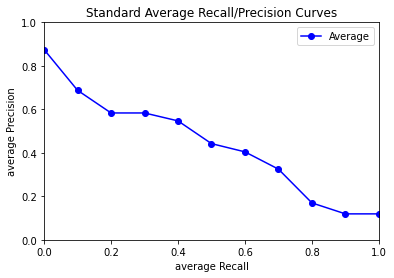

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# preprocess query
def preprocess_query(review, mode, vocab):
	# clean
	tokens = clean_doc(review)
	# convert to line
	line = ' '.join(tokens)
	# encode
	vectorizer = CountVectorizer(vocabulary=vocab)
	transformer = TfidfTransformer(norm='l2')
	encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
	return encoded

# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):
    if p >= 1.0:
        p = 0.9

    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
        if Recall[i] >= p and Mark[0] == 0:
            l = i
            Mark[0] = 1
        if Recall[i] >= p + 0.1 and Mark[1] == 0:
        # if Recall[i] >= 1.0 and Mark[1] == 0:
            r = i
            Mark[1] = 1
    y = max(Precision[l:(r+1)])
    return y

# obtain y axis for R/P curve
def compute_RP_yaxis(Precision=None, Recall=None):
  y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  for i in range(11):
    pInput = 0.1 * i
    y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
  return y_axis

# compute Recall, Precision, F1-measure
def compute_R_P_F1(re_mark=None, QuRe_ID =None):
  Recall = []
  Precision = []
  F1measure = []
  for i in range(len(re_mark)):
    r = sum(re_mark[:(i+1)])
    Re = r/(len(QuRe_ID))
    Pr = r/(i+1)   
    # avoid divisor to be 0
    FD = Re + Pr 
    if FD == 0:
      FD=1
    F1 = 2*Re*Pr/FD

    Recall.append(Re)
    Precision.append(Pr)
    F1measure.append(F1)
  return Recall, Precision, F1measure

queries = ['The ring is a great gift. My friend loves it',
          'horrible bad quality bracelet',
          'arrived promptly and happy with the seller',
          'wear it with casual wear',
          'i expected better quality. i will return this item',
          'looks beautiful. The design is pretty. pefect and color is light',
          'This ring looks nothing like the picture. the diamonds are small and not very noticeable',
          'braclet looked just like its picture and is nice quality sterling silver.',         
]

re_ID = list_of_Ids


AllRecall = []
AllPrecision = []
AllF1measure = []
y_axis_LSA = []
# loop queries
j = 0
for query in queries:
  # retrieval
  encoded_query = preprocess_query(query, 'tfidf', vocab)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)

  # rank the index
  indexes = np.argsort(similarities.flat)[::-1]

  # making a backup list for the indexes later
  indexes_dataframe = []
  for i in indexes:
    indexes_dataframe.append(i)
  #print(indexes_dataframe)

  # convert the index into real text index 
  for i in range(len(indexes)):
    indexes[i] = df.iloc[indexes[i]]['ID']
  print(f"this is the indexes{indexes}")
  

  # Mark the relevant index
  re_mark = []
  for i in range(len(indexes)):
    if (indexes[i]) in re_ID[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)
  print(f"this is the remark{re_mark}")

  # compute Recall, Precision, F1-measure
  Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])
  
  print('\n' + 'Query%d: '%(j+1) + query)
  for i in range(10):
    print("Top " + str(i+1) + ' result: ID%d '%(df.iloc[indexes_dataframe[i]]['ID']), str(df.iloc[indexes_dataframe[i]]['Reviews']))
  Recall = np.array(Recall)
  Precision = np.array(Precision)
  F1measure = np.array(F1measure)
  # print(re_mark)
  print("Recall@1~10: ", np.around(Recall[:10],8))
  print("Precision@1~10: ", np.around(Precision[:10],8))
  print("F1measure@1~10: ", np.around(F1measure[:10],8))

  # save
  AllRecall.append(Recall)
  AllPrecision.append(Precision)
  AllF1measure.append(F1measure)

  # plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  y_axis = compute_RP_yaxis(Precision=Precision, Recall=Recall)
  y_axis_LSA.append(y_axis)
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Standard Recall/Precision Curves')
  plt.legend()
  plt.show()

  j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)
AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[2] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[1] + AllPrecision[2]+ AllPrecision[3]+ AllPrecision[4]+ AllPrecision[5]+ AllPrecision[6]+ AllPrecision[7])/8
AveF1measure = (AllF1measure[0] + AllF1measure[1]+ AllF1measure[2]+ AllF1measure[3]+ AllF1measure[4]+ AllF1measure[5]+ AllF1measure[6]+ AllF1measure[7])/8

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(AveRecall[:10],8))
print("average Precision@1~10: ", np.around(AvePrecision[:10],8))
print("average F1measure@1~10: ", np.around(AveF1measure[:10],8))

# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)

plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

## 2b Remark and observation

while experimenting with the truncated number of component.  I find out that the higher the number of component give a better average. It does make sense since by increasing the number of component will result in a higher dimentional approximation. If the number is too low we might miss some key information.

## Question 3a Develop a neural information retrieval model

In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load the model

In [18]:
# importing all the libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')


In [19]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# get the embedding for the entire docs using the lecture slides

docs = pd.Series(train_docs)
with torch.no_grad():
    # Tokenization
    tokenized = docs[0:200].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    # padding
    max_len = 0
    q = 0
    for i in tokenized.values:
        
        # BERT only accept maximum 512 values
        if len(i) > 512:
            temp = tokenized.values[q]
            tokenized.values[q] = temp[:512]
            i = tokenized.values[q]
            print('too much tokenized.values for BERT, only 512 are taken')

        if len(i) > max_len:
            max_len = len(i)
        q += 1

    # making the padded matrix to get the same length
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    np.array(padded).shape

    # masking by making them into 0 or 1 
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    # run the model
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    last_hidden_states = model(input_ids, attention_mask=attention_mask)

    train_features = last_hidden_states[0][:,0,:].numpy()

print(len(train_features))  

200


In [21]:
# embedding for the queries
sentences = ['The ring is a great gift. My friend loves it',
          'horrible bad quality bracelet',
          'arrived promptly and happy with the seller',
          'wear it with casual wear',
          'i expected better quality. i will return this item',
          'looks beautiful. The design is pretty. pefect and color is light',
          'This ring looks nothing like the picture. the diamonds are small and not very noticeable',
          'braclet looked just like its picture and is nice quality sterling silver.',         
]
sentences_series = pd.Series(sentences)
with torch.no_grad():
    # Tokenization
    tokenized_querys = sentences_series[0:8].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    # padding
    max_len = 0
    q = 0
    for i in tokenized_querys.values:

        # BERT only accept maximum 512 values
        if len(i) > 512:
            temp = tokenized_querys.values[q]
            tokenized_querys.values[q] = temp[:512]
            i = tokenized_querys.values[q]
            print('too much tokenized.values for BERT, only 512 are taken')

        if len(i) > max_len:
            max_len = len(i)
        q += 1

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_querys.values])
    np.array(padded).shape

    # masking
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    # run the model
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print(input_ids.shape)

    last_hidden_states_query = model(input_ids, attention_mask=attention_mask)

    query_features = last_hidden_states_query[0][:,0,:].numpy()

print(len(query_features))


torch.Size([8, 18])
8


In [22]:
# function that does the queries embeddings
def process_sentence(j):
    with torch.no_grad():
        # Tokenization
        tokenized_querys = tokenizer.encode(sentences_series[j], add_special_tokens=True)
        # Padding
        if len(tokenized_querys) > 512:
            tokenized_querys = tokenized_querys[:512]
            print('Too many tokens for BERT. Only the first 512 tokens will be considered.')

        padded = np.array(tokenized_querys + [0]*(512-len(tokenized_querys)))
        padded = np.expand_dims(padded, axis=0)
        
        # Attention masks
        attention_mask = np.where(padded != 0, 1, 0)

        # Run the model
        input_ids = torch.tensor(padded)  
        attention_mask = torch.tensor(attention_mask)
        last_hidden_states_query = model(input_ids, attention_mask=attention_mask)
        query_features = last_hidden_states_query[0][:,0,:].numpy()
        
        return query_features

## now we implement the bert model

this is the converted index list [17442 45203 48216  3865 26246 28250 10535 52663 58481 32674 36727 41876
 14499 22946  6522  3494 22058 33858 57123 37896 10642  9050 36164   209
 11269  1816 44135 50640 28474 30926 43839 28543 22408 52375 52867 19852
 49720 17944   642 45548 25299 11247 19944 58595 47345 50197 10209  2185
 11087 48779 44126 53660  2134 36585 13373 56494 44489 56830 56830 56830
 39932   943  4375 10758 38305 44591 30720 56330 49216 17607 36677 45278
 56865 17304 41319 51396 44534 51474  8110 53409 26535  2520 27679  9726
 54748 44490 30773 37486 28648 25378 20090 50650 52837 29722 24452 42077
 41459 12358 30640 57009 39496 28542  6421  7110  2114 34266 13559 53693
   535 48781 15959 11856 17273 42604 50019 27858  2780 37794 56342 39606
 47910 36165  8341 41889  6135 50609 32767 45518 17166   265  6158  2131
 17309 35694 44358 40373 42026 40749 41872 34523 45146 23979 11135 54548
 11356  1185   735 21070  2033 10037 37864 34483 33746 32496 46347 43515
 35526 49525 27474

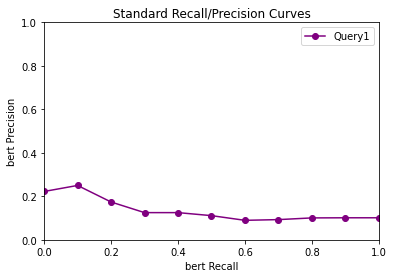

this is the converted index list [ 9050 58481  3865  3494 10642  1816   209 36727 52867 13373 28474 22946
 52375 19944 22058  6522 28250 10535 17944 57123 30926 14499 41876 17442
 45548 19852 52663 45203 48216   642 32674 48779 37896 47345 43839 22408
 11269 17607  2185 26246 49720 11247  4375 10758 56830 56830 56830 11087
 44126 10209 53660 50197 50640 44135   943 36164 30720 58595 44489 33858
  2134  8110 51396 44534 36677 56330 39932 28543 17304 25299 44490 49216
 54748 36585 56865 27679 41319 53409 37486 44591 29722 38305 42077  2520
  9726 56494 45278 30773 24452 30640 25378 52837 26535 13559 12358 51474
 41459   535  7110 28648 28542  2114 39496 57009 50019 53693 27858  2780
 41889 15959 20090 50650 34266 56342 48781 42604 36165 45518  6421 39606
 11856   265 37794 47910  6135 50609 17273 41872 32767 40373 44358  6158
  2131 34523 42026 23979  8341 11356 35694 17166 54548 45146 40749   735
 10037 33571 33746 37864  1185 17309 21070  9441 35526 43515 46347 32496
 27474 43945 34483

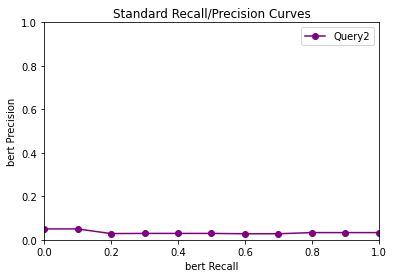

this is the converted index list [22058 52867 17944  1816 22408 10642 32674 36727 30926 17607 52663 14499
  3865 13373 19944 58481   209 11247 17442  3494   642  9050 48216 45203
 28474 41876 45548 37896 56830 56830 56830 28250 10535  2134 22946  6522
 10758  4375 52375 49720 57123 10209 54748 50197 26246 27679 47345 36677
 48779 44489 43839  2185  8110 28543 49216 33858 58595 29722 56494 11269
 44126 19852 53660   943 17304 11087 36164 50640 44135 56330 51396 44534
 39932 38305 30720 42077 44490 41319 36585 45278  9726 25299 56865 51474
  2520 30773 53409 44591 37486 50019 12358  2780 25378 26535   535 52837
 41889 30640 24452 28542 15959 13559 28648 50650 20090 34266 39496 57009
  7110 41459 39606 53693   265 42604  2114 48781 47910  6158  6421 27858
 45518 37794 36165 56342 11856 17273 50609  6135  8341 44358 41872 32767
 42026 40373  2131 17166 23979 34523 33571 11135 35694 40749 33251 11356
 45146 21070  1185 37864 54548 17309   735 33746 10037  9441 31657   216
 32496 43515 46347

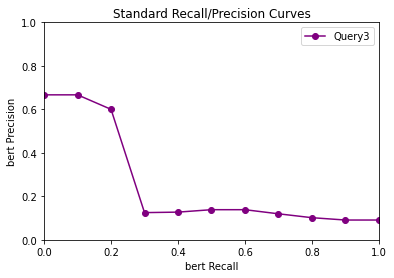

this is the converted index list [19852 53660  3865 52375  3494  6522  9050 44126 52663 22946  1816 30926
  2134   209 43839 19944 45548 10642 28474 58481 44135 50640 52867 28250
 10535 17944 13373 36727   642  2185 22058 45203 48216 49720 11087 57123
 14499 10758  4375 10209 50197 41876 17607 48779 56830 56830 56830 56330
 22408 11247 32674   943 37896 17442 30640 47345 26246 11269  8110 28543
 36677 51396 44534 33858 39932 44489 37486 36164 30720 58595 17304 36585
 25299 44490 27679 28648 53409 29722 41319 51474 24452 44591 56865 38305
 45278  9726   535 54748  2520 13559 49216 56494 42077 52837 26535 25378
 41459 39496 57009 30773  7110 50019 28542 12358 41889 15959  2114  2780
 50650 20090  2131 27858 53693 42604 34266   265 37794  6135 50609  6421
 39606 36165 56342 48781 45518 47910 11856 40373 32767 41872 17273 44358
  6158  8341 45146 54548 34523 42026 21070 17166   735 11356 23979 10037
 40749 33571 35694 33746  1185 37864 27474 43945  9441 11135 17309 33251
  2033 34483 31657

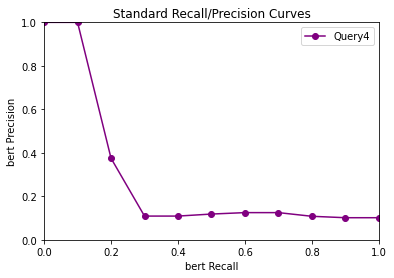

this is the converted index list [36727 14499 30926 17944 52663  1816 22058 17607 52867 22408 58481 48216
 45203  3494 57123 49720 45548  9050 17442 41876 28250 10535 56830 56830
 56830 13373  4375 10758  6522 32674  3865 19944   209 10642   642 22946
 11247 19852 52375 26246  8110 50197 37896 28474 28543 53660 27679 33858
 36677 43839 47345 11087 36164 48779 17304  2185  2134 44126 10209 44489
 11269 44135 50640 54748 30720 53409 25299   943 38305 58595 51396 44534
 39932  9726 44591 29722 56494 56330 49216  2520 36585 41319 30773 51474
 12358 44490 37486 41459 56865 45278 26535 42077 50019 30640  2114  2780
 28648 25378 20090 50650 41889   535  7110   265 24452 13559 52837 57009
 39496 15959 28542 48781 39606 34266 11856  6421 42604 53693 37794 27858
  6158 45518  6135 50609 56342 44358 47910  2131  8341 17273 36165 32767
 40373 42026 17166 41872 33571 45146 34523 17309 11135 35694 21070 23979
 37864 40749   735 54548 11356 32496 46347 35526 43515 33746 33251 10037
  2033 31657 51030

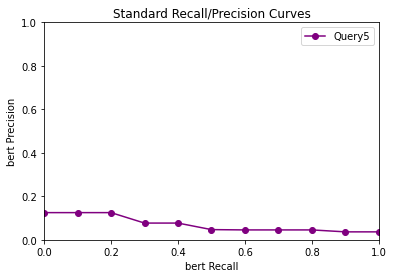

this is the converted index list [41319   642 56865 28542 44489 39932  2185 47345   943 42077 36677 57123
 53409   209 24452 44490 28648 10642 36727 52375   535  8341 51474  6522
 45278 25378 22408 38305 36165 25299 30640 41876 37794 28474 44126 58595
 50197 32674 12358 44135 50640 45518 11087 45203 48216 49720 52837 34266
 29722 33858 52663 45548 30926 11269 43839 28543 53660 49216 57009 39496
 20090 50650  2520 41872 17442 36585 22058 26246 14499 13373 28250 10535
 44591  7110 30720 42604 58481 56330 54748 44534 51396 37486  2114  8110
 48779 53693 10209 17944  9726 13559 27679 26535 32767 11247  6135 50609
 47910  3865 17304 27858 56494 36164 22946 40749 37896 56830 56830 56830
  4375 10758  2134 17273 17166 17607 39606   735  3494  6421 52867 34523
 19852 41889 41459  9050 10037 43945 27474  1816 15959 11356 21070  2780
 30773 45146  2131 56342   265 48781 44358 11856 50019 19944  1185 40373
 10612 37864 33746 35694 11135  6158 23979  2033 42026 38637 34483   216
 46500 54548 17309

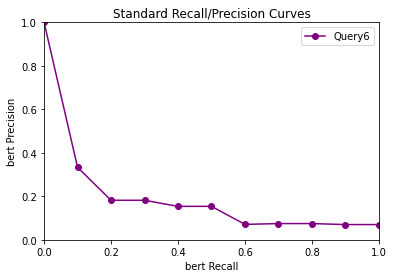

this is the converted index list [47345   209 36727 57123 52663  6522 28543 28474   642  2185 30926 10642
 53409 14499 22946 44534 51396 28250 10535 43839 58481 10209 44489 48216
 45203 41319  3865  9050 49720 36677 25299 45548 11269 48779 17442 37896
  3494 22408 13373 52375 41876  2520 26246 32674 56830 56830 56830   943
 22058  1816 58595 33858 50197 44490 17607 52867 11247 30720 17944 28542
 44135 50640 11087 38305 39932 30773 10758  4375 19852 44126 12358 53660
 56865  2114 42077 36164 19944 24452 44591  8110 45278 17304 25378 56330
  7110 27679 28648 49216 36585  9726 29722  2134 56494 54748 45518 30640
 39606 36165 50650 20090  6421 51474 32767 26535 15959 37486 41459 39496
 57009 48781 52837  6135 50609 37794 34266 27858   535 42604 53693 11856
 13559 47910 50019  2780 56342  8341 41889 44358   265 40749 41872 17166
 17273  2131   735 11356 23979 34523 42026 40373  6158 10037 45146 37864
 34483 35694  1185 21070 33746 35526 32496 46347 43515 54548 43945 27474
 33813 33571   216

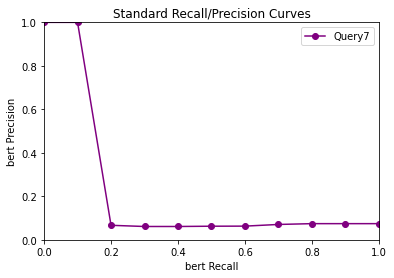

this is the converted index list [  642 53409 57123 41319  2185 36677 47345 36727 49720 56865 44490 38305
 12358 39932 37794 45278 25299 28542 44489 42077 24452   209   943 50197
 14499  2114 45518  7110 25378 44135 50640 41459 10642 30926 29722   535
 45548 11087 52663 28648 39496 57009 28474   735 22408 42604 52375 30720
 44126  2520  6522 58595 27679 32674 36165 41876 49216 11269 58481  8341
 51474 22058 30640 32767 17304 56830 56830 56830  6135 50609 15959 17442
  8110 13373 28543 10535 28250  9726 37896 17607 53660 41872 53693 50650
 20090 33858 17944 10037 54748 43839 26246 44591 56330 11247 47910 27858
 37486 51396 44534 36585 34266  4375 10758 48779 36164 52837 45203 48216
 52867 30773 13559  3865 10209  9050 44358  1816 39606  6421 40749 26535
  6158 22946 34523  3494 17166 41889 17273 19852 56342 56494   265 11856
 50019 48781 45146  2780  2131 40373 27474 43945 19944 33746 34483  2134
  2033 23979 37864 21070 33813 11135 11356 42026  9441 10612 35694   216
 33571  1185 33632

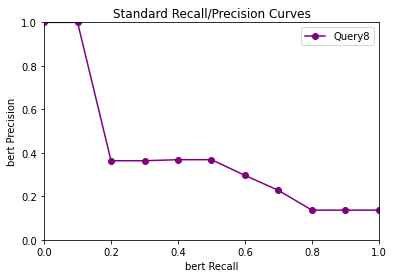


Average Recall, average Precision, average F1-measure: 
average Recall@1~10:  [0.04 0.07 0.08 0.08 0.1  0.11 0.11 0.14 0.15 0.16]
average Precision@1~10:  [0.5  0.5  0.37 0.28 0.28 0.25 0.21 0.22 0.21 0.2 ]
average F1measure@1~10:  [0.07 0.13 0.14 0.13 0.15 0.15 0.15 0.17 0.17 0.17]


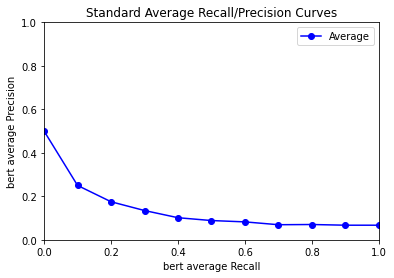

In [23]:
y_axis_bert = []
bert_AllRecall = []
bert_AllPrecision = []
bert_AllF1measure = []
top_ten_indexes_query = []
top_hundred_indexes_query = []
top_ten_indexes_query_unclean  = []

document_embeddings = train_features
# loop queries
j = 0
for bert_query in sentences:
  # retrieval 
  bert_similarities = cosine_similarity(process_sentence(j), document_embeddings)
  # here we sort the bert similarities
  bert_indexes = np.argsort(bert_similarities.flat)[::-1] 

  # we make a list where we get the first hundred
  top_hundred_indexes = bert_indexes[:100]

  # here we make another list and store their reviews with it 
  for i in range(len(top_hundred_indexes)):
     top_hundred_indexes_query.append(train_docs[top_hundred_indexes[i]])

  # here making a list where we get the first 10 
  top_ten_indexes = bert_indexes[:10]
  
  # here we make another list and store their CLEAN reviews with it
  for i in range(len(top_ten_indexes)):
     top_ten_indexes_query.append(train_docs[top_ten_indexes[i]])

  # here we make another list and store their UNCLEAN reviews with it
  for i in range(len(top_ten_indexes)):
    top_ten_indexes_query_unclean.append(unclean_docs[top_ten_indexes[i]])
  
  # now i will convert the index back to the dataframe index
  for i in range(len(bert_indexes)) :
    bert_indexes[i] = df.iloc[bert_indexes[i]]['ID']
  
  print(f"this is the converted index list {bert_indexes}")

  
  # Mark the relevant index
  bert_re_mark = []
  for i in range(len(bert_indexes)):
    if (bert_indexes[i]) in re_ID[j]:
      bert_re_mark.append(1)
    else:
      bert_re_mark.append(0)
  print(f"this is the remark {bert_re_mark}")

  # compute Recall, Precision, F1-measure
  bert_Recall, bert_Precision, bert_F1measure = compute_R_P_F1(re_mark=bert_re_mark, QuRe_ID=re_ID[j])
  
  print('\n' + 'Query%d: '%(j+1) + query)
  for i in range(10):
    print("Top " + str(i+1) + ' result: ID%d '%(top_ten_indexes[i]), top_ten_indexes_query[i])
  bert_Recall = np.array(bert_Recall)
  bert_Precision = np.array(bert_Precision)
  bert_F1measure = np.array(bert_F1measure)
  # print(re_mark)
  print("bert Recall@1~10: ", np.around(bert_Recall[:10],2))
  print("bert Precision@1~10: ", np.around(bert_Precision[:10],2))
  print("bert F1measure@1~10: ", np.around(bert_F1measure[:10],2))

  # save
  bert_AllRecall.append(bert_Recall)
  bert_AllPrecision.append(bert_Precision)
  bert_AllF1measure.append(bert_F1measure)

  # plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  y_axis = compute_RP_yaxis(Precision=bert_Precision, Recall=bert_Recall)
  y_axis_bert.append(y_axis)
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('bert Recall')
  plt.ylabel('bert Precision')
  plt.title('Standard Recall/Precision Curves')
  plt.legend()
  plt.show()

  j += 1  

# compute average Recall, average Precision, average F1-measure
bert_AllRecall = np.array(bert_AllRecall)
bert_AllPrecision = np.array(bert_AllPrecision)
bert_AllF1measure = np.array(bert_AllF1measure)
bert_AveRecall = (bert_AllRecall[0] + bert_AllRecall[1] + bert_AllRecall[2] + bert_AllRecall[3] + bert_AllRecall[4] + bert_AllRecall[5] + bert_AllRecall[6] + bert_AllRecall[7])/8
bert_AvePrecision = (bert_AllPrecision[0] + bert_AllPrecision[1] + bert_AllPrecision[2]+ bert_AllPrecision[3]+ bert_AllPrecision[4]+ bert_AllPrecision[5]+ bert_AllPrecision[6]+ bert_AllPrecision[7])/8
bert_AveF1measure = (bert_AllF1measure[0] + bert_AllF1measure[1]+ bert_AllF1measure[2]+ bert_AllF1measure[3]+ bert_AllF1measure[4]+ bert_AllF1measure[5]+ bert_AllF1measure[6]+ bert_AllF1measure[7])/8


print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(bert_AveRecall[:10],2))
print("average Precision@1~10: ", np.around(bert_AvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(bert_AveF1measure[:10],2))

# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=bert_AvePrecision, Recall=bert_AveRecall)

plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('bert average Recall')
plt.ylabel('bert average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

We can see that the bert retrival recall and precision are not as good as the LSI.Maybe because there is not enough data for the model to learn enough. The bert model showed good performance on some queries and bad on other queries.

# 3b creative part asking the user input 

Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): 1

Query2: braclet looked just like its picture and is nice quality sterling silver.


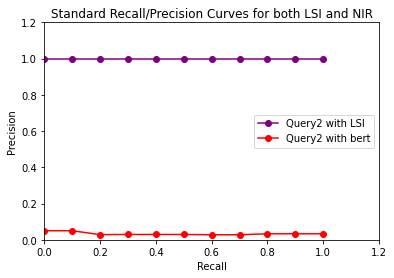

Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): 8


In [24]:
def plotting_graph(index):
  # for index, query in enumerate(querys):
    # plot R/P curves for both NRI and LSI methods
  print('\n' + 'Query%d: '%(index+1) + query)
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  LSI_y_axis = y_axis_LSA[index]
  NRI_y_axis = y_axis_bert[index]
  plt.plot(x_axis, LSI_y_axis, '-bo', color="purple", label="Query%d with LSI"%(index+1))
  plt.plot(x_axis, NRI_y_axis, '-bo', color="red", label="Query%d with bert"%(index+1))
  plt.xlim(0, 1.2)
  plt.ylim(0, 1.2)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Standard Recall/Precision Curves for both LSI and NIR')
  plt.legend()
  plt.show()

loop = True 
while loop:
    try:
        num = int(input("Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): "))
    except ValueError:
        print("Invalid input. Please enter an integer.")
        continue
        
    if num == 8:
        loop = False
        break
    if num > 8:
        print("The highest index in sentences is 7.")
        continue
    elif num < 0:
        print("Index has to be positive.")
        continue
    else:
        plotting_graph(num)



# 4 topic modelling

4 a ) and 4b)

for 4b ) it will ask for an index that index will reprensent the queries. It will return you the topic modelling on that query

In [25]:
top_hundred_indexes_query_100 =[]
# Loop over the top_hundred_indexes_query list, slicing it into 100-elements chunks at each iteration
for i in range(0, 800, 100):
    # making the list of 8 list into 100 items
    top_hundred_indexes_query_100.append(top_hundred_indexes_query[i:i+100])

In [26]:
%%capture
!pip install bertopic

In [27]:
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
import matplotlib.pyplot as plt


def topic_modelling(index):
  # perform the topic modelling 
  topic_model = BERTopic(calculate_probabilities=True)
  topics, probs = topic_model.fit_transform(top_hundred_indexes_query_100[index])

  # looking at the frequency 
  freq = topic_model.get_topic_info()
  freq.head(10)

  topic_model.get_topic(0)  # Select the most frequent topic

  # save all the plot 
  o =topic_model.visualize_distribution(probs[90], min_probability=0.0001)

  p =topic_model.visualize_hierarchy(top_n_topics=10)

  q =topic_model.visualize_barchart(top_n_topics=5)

  return o,p,q


loop = True 
while loop:
    try:
        num = int(input("Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): "))
    except ValueError:
        print("Invalid input. Please enter an integer.")
        continue
    if num == 8:
        loop = False
        break
    if num > 7:
        print("The highest index in sentences is 7.")
        continue
    elif num < 0:
        print("Index has to be positive.")
        continue
    else:
      o,p,q = topic_modelling(num)
      o.show()
      p.show()
      q.show()


Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): 1


Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): 8


In order to do topic modelling, I found that using 10 reviews wasn t enough. Therefore I took the 100 best instead of 10. Next each query have a different topics.

# question 5 Summarisation of search results



In [28]:
# Download SummerTime 
# Swith to the Summertime directory

!git clone https://github.com/Yale-LILY/SummerTime.git
%cd SummerTime/

fatal: destination path 'SummerTime' already exists and is not an empty directory.
/content/SummerTime


In [29]:
# Pip install Summertime locally
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/SummerTime
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached transformers-4.5.1-py3-none-any.whl (2.1 MB)
  Using cached huggingface_hub-0.0.19-py3-none-any.whl (56 kB)
  Using cached tokenizers-0.10.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.2
    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.1
    Uninstalling transformers-4.27.1:
      Successfully uninstalled transformers-4.27.1
  Attempting uninstall: huggingface-hub
    Found existin

In [30]:
# Setup ROUGE (needed to use ROUGE evaluation metric)
!export ROUGE_HOME=/usr/local/bin/python/dist-packages/summ_eval/ROUGE-1.5.5/
!pip install -U  git+https://github.com/bheinzerling/pyrouge.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bheinzerling/pyrouge.git to /tmp/pip-req-build-eep6fsnp
  Running command git clone --filter=blob:none --quiet https://github.com/bheinzerling/pyrouge.git /tmp/pip-req-build-eep6fsnp
  Resolved https://github.com/bheinzerling/pyrouge.git to commit 08e9cc35d713f718a05b02bf3bb2e29947d436ce
  Preparing metadata (setup.py) ... done


In [31]:
# Then run this cell to go back to the relevant directory

%cd /content/SummerTime/

/content/SummerTime


In [32]:
# !pip install en_core_web_sm==3.0.0
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-17 11:43:27.637765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 11:43:27.637841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 11:43:27.637854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [33]:
# separate the list into 8 set of 10 items
sets_of_10 = []
set_of_10_unclean = []
sets_of_10 = [top_ten_indexes_query[i:i+10] for i in range(0, len(top_ten_indexes_query), 10)]
sets_of_10_unclean = [top_ten_indexes_query_unclean[i:i+10] for i in range(0, len(top_ten_indexes_query_unclean), 10)]
print(sets_of_10)

[['addiction wonderful sending ring ring beautiful daughter waas thrilled ring thank', 'ring birthday love cannot imagine woman adoring', 'ring birthday love cannot imagine woman adoring', 'pretty dainty', 'gift yo niece love ring happy', 'know ring like ring one ring beyond gorgeous', 'know ring like ring one ring beyond gorgeous', 'ring comfortable wear quite surprised please see masonic ring', 'love ring great gift extremelly cheap high', 'wonderful surprise quality much could ever'], ['pretty enough metal ring insubstantial push', 'love ring great gift extremelly cheap high', 'pretty dainty', 'look picture', 'looked purple clear like title', 'look anticipated flimsyi would recommend', 'look nothing like picture diamond small noticeable sending', 'one jewel fell wing metal already tarnishing spend money higher quality', 'arrived perfect condition shipping ridiculously slow', 'pictured funky poor quality seller respond'], ['great quality came promptly im happy recommend', 'arrived pe

In [34]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.27.1-py3-none-any.whl (6.7 MB)
  Using cached tokenizers-0.13.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached huggingface_hub-0.13.2-py3-none-any.whl (199 kB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [35]:
from summertime import model

In [36]:
top_ten_indexes_query_unclean[0]

"Eve's Addiction was wonderful with sending the ring and the ring is beautiful; my daughter waas thrilled with the ring. Thank you, Dorothy"

In [37]:
# here we are using the lexrank model to make the summary
summaries = []

# here we loop so the model can loop through each queries
for index in range(len(sets_of_10_unclean)):
  lexrank = model.LexRankModel(sets_of_10_unclean[index])
  query_summeries = []
  summaries.append(query_summeries)

  # Inference
  summary = lexrank.summarize(sets_of_10_unclean[index])
  for i in range(len(summary)):
    print("Summary Review %d: "%(i+1), summary[i])
    query_summeries.append(summary[i])
  print('\n')

Summary Review 1:  Thank you, Dorothy Eve's Addiction was wonderful with sending the ring and the ring is beautiful; my daughter waas thrilled with the ring.
Summary Review 2:  I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.
Summary Review 3:  I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.
Summary Review 4:  Just what I was looking for. It is so pretty and dainty.
Summary Review 5:  She loves the ring and was very happy to have received it. This was a birthday gift for my 16 YO niece.
Summary Review 6:  I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
Summary Review 7:  I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
Summary Review 8:  I have been told that the ring is very comfortable to wear and he was quite surprised and please to see the Masonic ring in titanium.
Summary 

In [38]:
from summertime.evaluation import SUPPORTED_EVALUATION_METRICS

print(SUPPORTED_EVALUATION_METRICS)

import summertime.evaluation as st_eval

bert_eval = st_eval.BertScore()

from summertime import dataset, model
from pprint import pprint
from summertime.evaluation import BertScore
from summertime.evaluation import Meteor
from summertime.evaluation import Bleu

# the target is the summarization from chat-gpt
targets = ["Dorothy is grateful to Eve's Addiction for sending a beautiful ring that made her daughter happy.",
          "The ring looks nice, but the metal is insubstantial and dents easily",
          "The item was of great quality, arrived quickly, and the person is very happy with it, highly recommending it without any reservations.",
          "Suitable for both casual wear and formal occasions.",
          "After a week of having it, one jewel fell out of the wing and the metal is already tarnishing. Suggests investing money in a higher quality item instead.",
           "The ring matches the picture description, looks pretty on the hand, and has rich and beautiful colored stones.",
          "The diamonds in the product looked different from the picture and had significant flaws, causing the person not to like it.",
          "The medical alert bracelet is made of nice quality sterling silver and matches the picture description.",       
]

[<class 'summertime.evaluation.bertscore_metric.BertScore'>, <class 'summertime.evaluation.bleu_metric.Bleu'>, <class 'summertime.evaluation.rouge_metric.Rouge'>, <class 'summertime.evaluation.rougewe_metric.RougeWe'>, <class 'summertime.evaluation.meteor_metric.Meteor'>]


In [39]:
top1_summary = []

for i in range(0,8):
  top1_summary.append(summaries[i][0])

print(top1_summary[0])
print(top_ten_indexes_query_unclean[0])

Thank you, Dorothy Eve's Addiction was wonderful with sending the ring and the ring is beautiful; my daughter waas thrilled with the ring.
Eve's Addiction was wonderful with sending the ring and the ring is beautiful; my daughter waas thrilled with the ring. Thank you, Dorothy


In [40]:
# Calculate BertScore
bert_metric = BertScore()
bert_metric.evaluate(top1_summary, targets)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


hash_code: bert-base-uncased_L8_no-idf_version=0.3.12(hug_trans=4.27.1)


{'bert_score_f1': 0.6773407459259033}

5b)

In [41]:

def summary_choice(index):
  lexrank = model.LexRankModel(sets_of_10_unclean[index])

  # Inference
  summary = lexrank.summarize(sets_of_10_unclean[index])
  for i in range(len(summary)):
    print("Summary Review %d: "%(i+1), summary[i])
  

loop = True 
while loop:
    try:
        num = int(input("Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): "))
    except ValueError:
        print("Invalid input. Please enter an integer.")
        continue
    if num == 8:
        loop = False
        break
    if num > 7:
        print("The highest index in sentences is 7.")
        continue
    elif num < 0:
        print("Index has to be positive.")
        continue
    else:
      summary_choice(num)

Enter a sentence index (btw 0 and 7) to graph (or 8 to exit): 8


# Reference 

https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing